In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import torchvision
import numpy as np
import shutil
import random
import torch
import os

%matplotlib inline

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.9.0+cpu


In [2]:
class_names = ['normal', 'viral', 'covid']
root_dir    = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name): 
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')] 
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
          
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index%len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [4]:

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [5]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:

train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

In [7]:
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [8]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

In [9]:
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [10]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 470
Number of test batches 15


In [11]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean  = np.array([0.485, 0.456, 0.406])
        std   = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col   = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

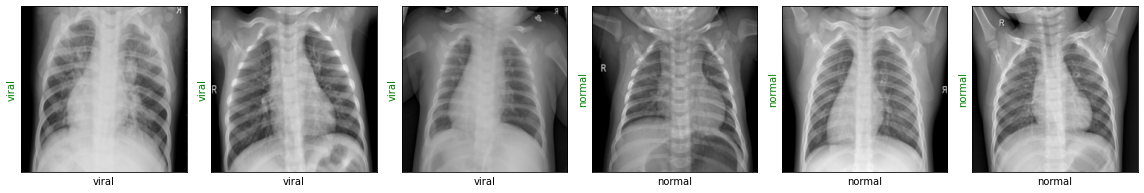

In [12]:

images, labels = next(iter(dl_train))
show_images(images, labels, labels)

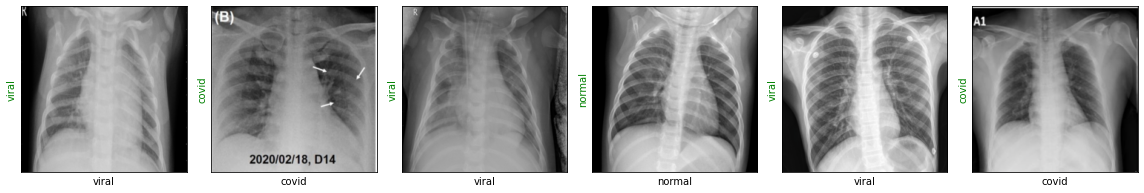

In [13]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

In [48]:
resnet50 = torchvision.models.resnet50(pretrained = True)

print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:

resnet50.fc = torch.nn.Linear(in_features = 2048, out_features = 3)
loss_fn     = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.Adam(resnet50.parameters(), lr = 3e-5)

In [16]:

def show_preds():
    resnet50.eval()
    images, labels = next(iter(dl_test))
    outputs  = resnet50(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

C:\Users\sandas\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


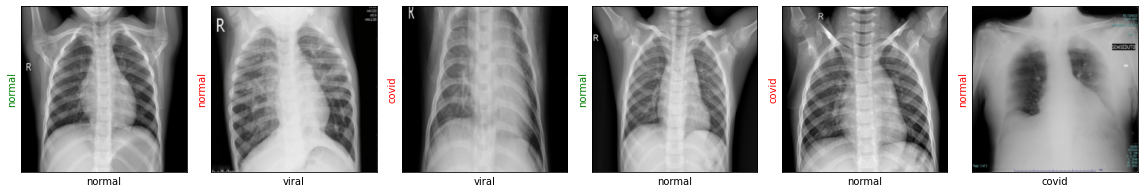

In [17]:
show_preds()

In [18]:
""""
def train(epochs):
    print('Starting training..')
    start_time = time.time()
    running_train_loss = []
    running_val_loss = []
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet50.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet50(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet50.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet50(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                current_time = time.time()
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()
                running_val_loss.append(val_loss)

                resnet50.train()

                if accuracy >= 0.96:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)
        running_train_loss.append(train_loss)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')
    
""""

SyntaxError: EOL while scanning string literal (<ipython-input-18-33b69377667c>, line 59)

In [19]:
def train(epochs):
    
    print('Start training..')
    
    start_time = time.time()
    running_train_loss = []
    running_val_loss = []
    
    for epoch in range(epochs):
        
        print('='*20)
        print(f'Starting epoch {epoch + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet50.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            
            #images = images.to(device)
            #labels = labels.to(device)
            optimizer.zero_grad()
            outputs = resnet50(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                
                accuracy = 0
                resnet50.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    
                    #images = images.to(device)
                    #labels = labels.to(device)
                    outputs = resnet50(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).cpu().numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                current_time = time.time()
                
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f} Training time: {(current_time-start_time)//60:.0f} minutes')

                show_preds()
                
                running_val_loss.append(val_loss)

                resnet50.train()

                if accuracy >= 0.96:
                    print('Performance condition satisfied, stopping..')
                    save_file = 'resnet50.pt'
                    torch.save(resnet50.state_dict(), save_file)
                    return running_train_loss, running_val_loss

            train_loss /= (train_step + 1)
            running_train_loss.append(train_loss)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Start training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.1427, Accuracy: 0.3222 Training time: 0 minutes


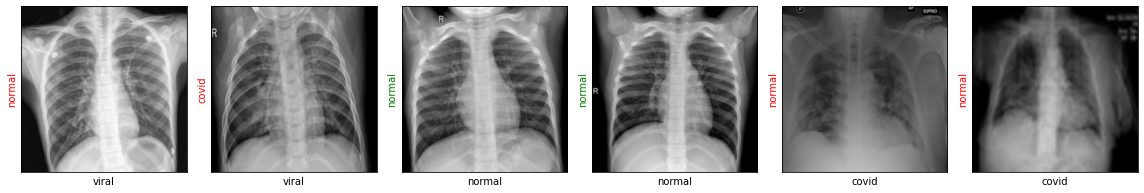

Evaluating at step 20
Validation Loss: 0.6552, Accuracy: 0.8667 Training time: 1 minutes


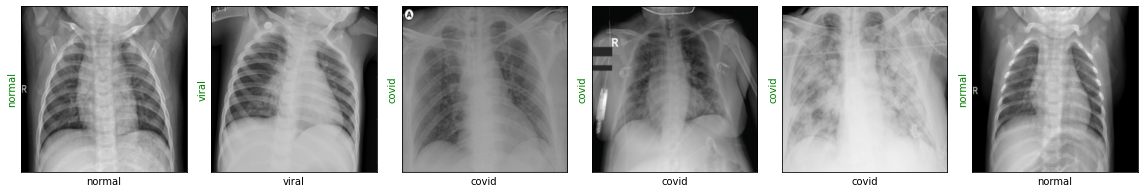

Evaluating at step 40
Validation Loss: 0.2684, Accuracy: 0.9556 Training time: 2 minutes


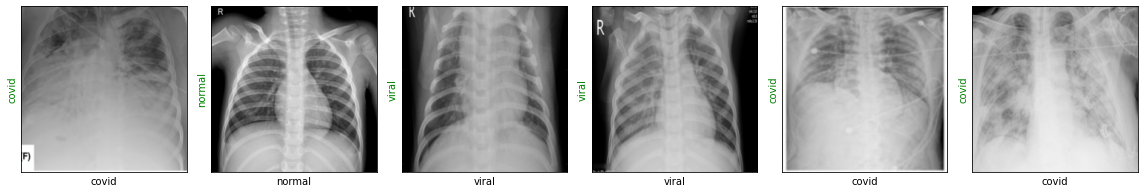

Evaluating at step 60
Validation Loss: 0.2697, Accuracy: 0.9222 Training time: 3 minutes


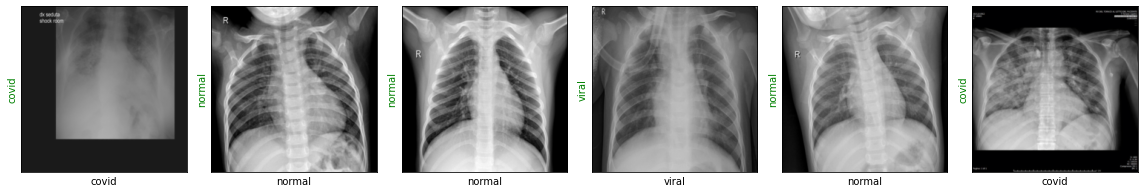

Evaluating at step 80
Validation Loss: 0.2120, Accuracy: 0.9556 Training time: 4 minutes


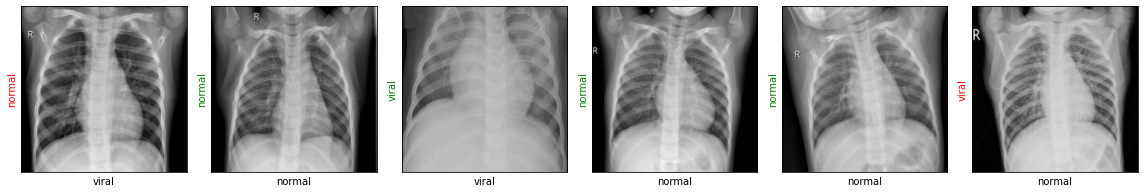

Evaluating at step 100
Validation Loss: 0.1693, Accuracy: 0.9333 Training time: 5 minutes


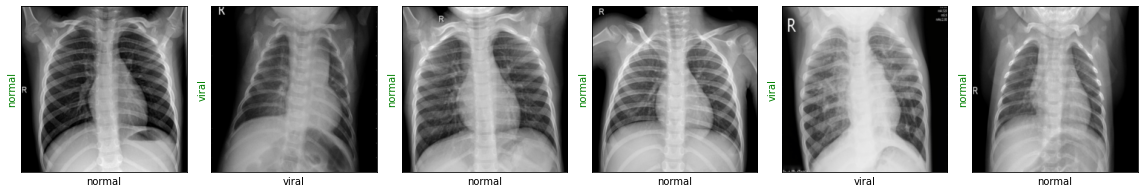

Evaluating at step 120
Validation Loss: 0.0910, Accuracy: 0.9889 Training time: 6 minutes


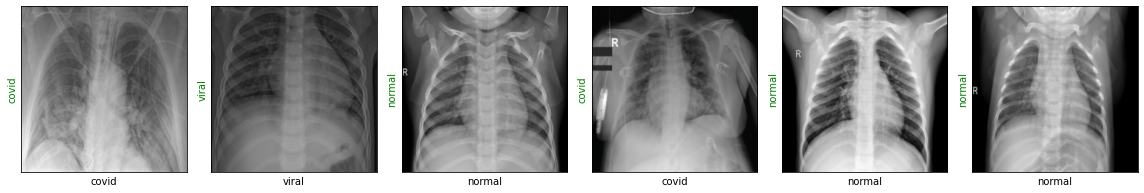

Performance condition satisfied, stopping..
Wall time: 6min 55s


In [20]:
%%time
import time
running_train_loss, running_val_loss = train(epochs=1)

In [21]:
running_train_loss

[1.092812180519104,
 1.1169178485870361,
 0.702254076798757,
 0.46944156785806024,
 0.29140254954497025,
 0.21539965785211987,
 0.16773674816839276,
 0.10983412455885656,
 0.09130632766018205,
 0.10327204454732923,
 0.10900551296435791,
 0.07676838853058136,
 0.05858602815568211,
 0.06803144067078812,
 0.05331813961237668,
 0.04629887247456237,
 0.04568232923417297,
 0.050989012933257,
 0.03598291837418721,
 0.03231233714185389,
 0.02646756756786422,
 0.026232050489514123,
 0.024555957258228334,
 0.021349082636356514,
 0.015293054987888341,
 0.01625848134396553,
 0.011438788205031289,
 0.01670296068807598,
 0.009998618897288748,
 0.012909378586096556,
 0.00978376967861713,
 0.01005707479490416,
 0.010502211462660744,
 0.0074863203662050735,
 0.013343395699482341,
 0.015116098906966857,
 0.010857813352571221,
 0.0036296642609391894,
 0.007139294821961197,
 0.0033690970261629287,
 0.010262304062571313,
 0.01177755337657735,
 0.004451061829509246,
 0.00368507568909774,
 0.0171225234015946

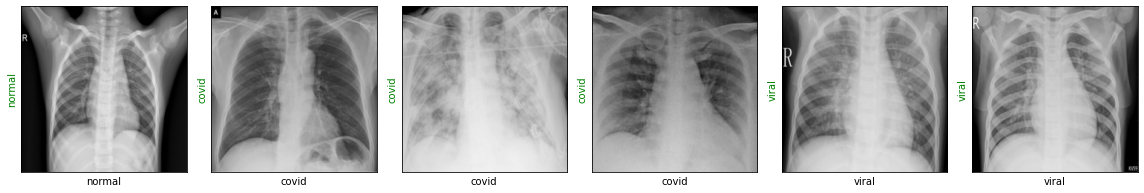

In [22]:

show_preds()

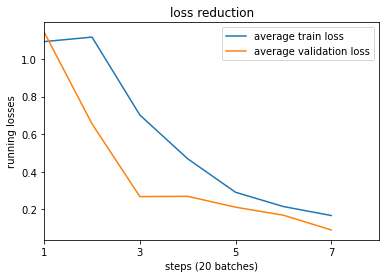

In [23]:
# Plot Loss reduction profile
steps = len(running_val_loss)
plt.plot(np.arange(1, steps+1,1),running_train_loss[:steps], label='average train loss')
plt.plot(np.arange(1,steps+1,1), running_val_loss[:steps], label='average validation loss')
plt.xticks(range(1,steps+1,2))
plt.xlim(1,steps+1)
plt.xlabel('steps (20 batches)')
plt.ylabel('running losses')
plt.title('loss reduction')
plt.legend(loc='upper right')
filename = 'loss_profile.png'
plt.savefig(filename)
plt.show()

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# Calculate accuracy by class
print('calculating model accuracy after training....')
num_classes = len(class_names)
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
    
resnet50.eval()      
for val_step, (images, labels) in enumerate(dl_test):
    images, labels = images.to(device), labels.to(device)
    outputs = resnet50(images)
    _, preds = torch.max(outputs, dim=1)
    
    correct_tensor = preds.eq(labels.view_as(preds))    # equivalent to tensor.view(preds.size())
    correct = np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = labels[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
for i in range(num_classes):
    if class_total[i] > 0:
            
        print('Test Accuracy on {}:'.format(class_names[i]),
              ' {:.0f}%'.format(100 * class_correct[i] / class_total[i]).ljust(10,' '), 
              '({:.0f}/{:.0f})'.format(np.sum(class_correct[i]), np.sum(class_total[i])))
            
    else:
        print('Test Accuracy of {}: N/A (no training examples)'.format(labels[i]))
                      
print('\nTest Accuracy (Overall):\t {:.0f}%'.format(100. * np.sum(class_correct) / np.sum(class_total)).expandtabs(25),
      '\t({:.0f}/{:.0f})'.format(np.sum(class_correct), np.sum(class_total)).expandtabs(5))

calculating model accuracy after training....
Test Accuracy on normal:  92%       (23/25)
Test Accuracy on viral:  97%       (32/33)
Test Accuracy on covid:  100%      (32/32)

Test Accuracy (Overall):  97%      (87/90)


In [44]:
# Show the images and the ground truth
dataiter = iter(dl_test)
images, labels = dataiter.next()
##imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ', '.join('%5s' % class_names[x] for x in labels))

# Predict the model
images,labels = next(iter(dl_test))
labels = images.to(device)
output = resnet50(images)
_, preds= torch.max(output, 1)
print('Predicted: ', ', '.join('%5s' % class_names[x] for x in preds))

GroundTruth:  normal, covid, viral, viral, viral, viral
Predicted:  covid, covid, covid, viral, normal, normal


In [42]:

def show_preds():
    resnet50.eval()
    images, labels = next(iter(dl_test))
    outputs  = resnet50(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

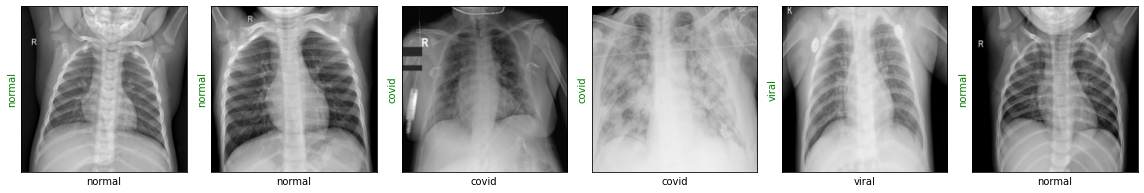

In [43]:
show_preds()

In [50]:
!pip install torchsummary 